In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

# Dataset 살펴보기

In [2]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root = "./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root = "./data", train=False, download=True, transform=transform)

In [3]:
print(train_dataset)
print(len(train_dataset))

print(test_dataset)
print(len(test_dataset))

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
60000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
10000


In [4]:
train_dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [5]:
train_dataset.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [6]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

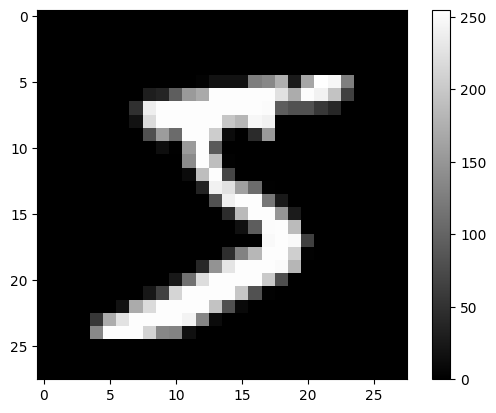

In [7]:
plt.imshow(train_dataset.data[0], cmap="gray")
plt.colorbar()

In [8]:
print(train_dataset.targets)
print(train_dataset.targets.shape)

tensor([5, 0, 4,  ..., 5, 6, 8])
torch.Size([60000])


# DataLoader 살펴보기

In [9]:
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [10]:
print(len(train_dataloader.dataset))

60000


<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([32, 1, 28, 28])
torch.Size([32])
tensor(2)
torch.uint8
torch.float32


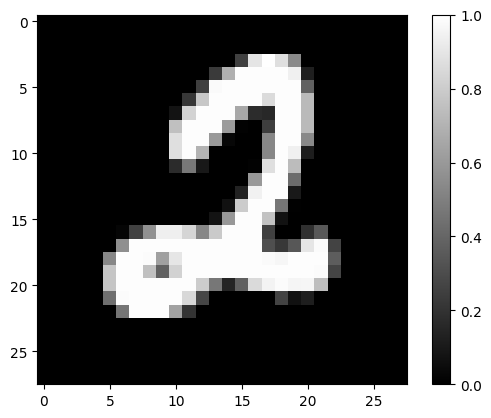

In [11]:
# 배치 실행
x_batch, y_batch = next(iter(train_dataloader))
print(type(train_dataset.data))
print(type(x_batch))
print(x_batch.shape)
print(y_batch.shape)
plt.imshow(x_batch[0].squeeze(), cmap="gray")
plt.colorbar()
print(y_batch[0])

# 타입이 달라짐
print(train_dataloader.dataset.data.dtype)
print(x_batch.dtype)



# 모델 만들기

In [12]:
from torch import nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 10)            
        )
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return x
    

In [13]:
# flatten
x_batch, y_batch = next(iter(train_dataloader))
print(x_batch.shape)
flat_images = torch.flatten(x_batch)
print(flat_images.shape)
flat_images_2 = torch.flatten(x_batch, start_dim=1)
print(flat_images_2.shape)


torch.Size([32, 1, 28, 28])
torch.Size([25088])
torch.Size([32, 784])


In [14]:
# create a model instance
model = MLP().to(device)
print(model)

# model test
x_batch, y_batch = next(iter(train_dataloader))
print(model(x_batch.to(device)).shape)

MLP(
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)
torch.Size([32, 10])


In [15]:
from torch import optim

def train_model(model, criterion, optimizer, train_dataloader, epoch_num):
    loss_hist = []
    model.train()
    for ep in range(epoch_num):
        loss_r = 0  # running loss
        for x_batch, y_batch in train_dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            # inference
            y_hat = model(x_batch)
            # loss
            loss = criterion(y_hat, y_batch)
            # update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # loss accumulation
            loss_b = loss.item() * x_batch.shape[0]  # dataloader의 짜투리를 처리하기 유리함
            loss_r += loss_b
        # print loss        
        loss_e = loss_r / len(train_dataloader.dataset)
        loss_hist.append(loss_e)
        print(f"Epoch: {ep+1}, train loss: {round(loss_e, 3)}")
        print("_" * 30)
    return loss_hist
    

### softmax

In [16]:
import torch.nn.functional as F

y_hat = torch.randn(3, 5)  # 데이터는 3 개, 5 종류로 분류되는 문제 가정
print(y_hat)

y_batch = torch.randint(5, (3, ))  # 0~4에서 3개를 선택
print(y_batch)

# 방법 1
loss = F.cross_entropy(y_hat, y_batch)  # softmax가 내장됨
print(loss)

# 방법 2
criterion = nn.CrossEntropyLoss()  # softmax가 내장됨
print(criterion(y_hat, y_batch))

# 방법 3
y_hat_soft = F.softmax(y_hat, dim=1)
print(y_hat_soft)
loss = 0
for i, val in enumerate(y_hat_soft):
    loss += -torch.log(val[y_batch[i]])
print(loss/3)

tensor([[ 0.7528, -1.3943, -0.2680, -0.4458, -0.8579],
        [-0.8649,  0.2799,  0.1659,  0.7576, -0.0232],
        [-0.0463, -0.1498, -0.7228,  1.1206,  1.7810]])
tensor([2, 1, 4])
tensor(1.2883)
tensor(1.2883)
tensor([[0.5054, 0.0590, 0.1821, 0.1525, 0.1010],
        [0.0698, 0.2192, 0.1956, 0.3535, 0.1619],
        [0.0845, 0.0762, 0.0429, 0.2713, 0.5251]])
tensor(1.2883)


# 모델 학습하기

Epoch: 1, train loss: 0.288
______________________________
Epoch: 2, train loss: 0.12
______________________________
Epoch: 3, train loss: 0.083
______________________________
Epoch: 4, train loss: 0.062
______________________________
Epoch: 5, train loss: 0.049
______________________________
Epoch: 6, train loss: 0.039
______________________________
Epoch: 7, train loss: 0.035
______________________________
Epoch: 8, train loss: 0.028
______________________________
Epoch: 9, train loss: 0.025
______________________________
Epoch: 10, train loss: 0.02
______________________________
Epoch: 11, train loss: 0.02
______________________________
Epoch: 12, train loss: 0.017
______________________________
Epoch: 13, train loss: 0.016
______________________________
Epoch: 14, train loss: 0.014
______________________________
Epoch: 15, train loss: 0.014
______________________________
Epoch: 16, train loss: 0.012
______________________________
Epoch: 17, train loss: 0.012
_______________________

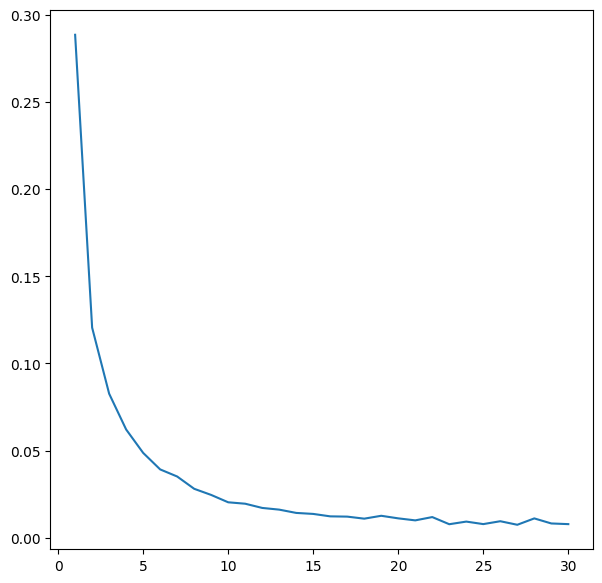

In [17]:
learning_rate = 1e-3
epoch_num = 30
train_num = len(train_dataloader.dataset)

model = MLP().to(device)  # 순서 중요

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # model을 먼저 만들어야 함

loss_hist = train_model(model, criterion, optimizer, train_dataloader, epoch_num)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(range(1, epoch_num+1), loss_hist)

# 모델 저장하기 & 불러오기

In [18]:
path = "./model/MLP_MNIST.pt"
torch.save(model.state_dict(), path)
model.state_dict()

OrderedDict([('linear.0.weight',
              tensor([[ 0.0354,  0.0280,  0.0062,  ...,  0.0251,  0.0023, -0.0160],
                      [ 0.0352,  0.0303, -0.0087,  ...,  0.0049, -0.0111, -0.0051],
                      [ 0.0225, -0.0313, -0.0337,  ...,  0.0041, -0.0167, -0.0040],
                      ...,
                      [-0.0053,  0.0332, -0.0147,  ..., -0.0300, -0.0246, -0.0026],
                      [-0.0227, -0.0342,  0.0129,  ..., -0.0323,  0.0056,  0.0341],
                      [ 0.0180, -0.0296, -0.0007,  ..., -0.0197,  0.0329,  0.0346]],
                     device='cuda:0')),
             ('linear.0.bias',
              tensor([-1.1557e-01,  2.3098e-02, -2.9470e-01, -1.0347e-02,  2.2448e-01,
                       4.8356e-02,  1.6527e-01,  1.5200e-01, -7.6151e-02, -6.9573e-02,
                       6.3304e-03, -1.8506e-02,  9.4180e-02, -3.9999e-02, -2.1713e-02,
                      -1.6950e-02, -2.7449e-02, -4.8284e-01,  2.1316e-01, -1.9298e-01,
                

In [19]:
load_model = MLP().to(device)
load_model.load_state_dict(torch.load(path, map_location=device))

<All keys matched successfully>

## 모델 테스트

In [21]:
model.eval()
with torch.no_grad():
    correct_run = 0
    for x_batch, y_batch in test_dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        # inference
        y_hat = model(x_batch)
        # accuracy accumulation
        pred = y_hat.argmax(dim=1)
        correct_run += torch.sum(pred == y_batch).item()
    acc = correct_run/len(test_dataloader.dataset)*100
    print(f"Test accuracy: {acc}")

Test accuracy: 98.1
